![Array%20Electropshyiology%20copy.png](attachment:Array%20Electropshyiology%20copy.png)

# DataJoint Workflow Array Ephys

Now that we have ingested the data into `workflow-array-ephys`, it is time to explore it. This notebook describes steps for interacting with this data.

Exploring the data is the culumination of all the work we have done. Ingesting and curating the data leaves us with 'good' data. This notebook describes ways to interact with this newly curated data and shows several strengths inside DataJoint. 



In [1]:
#We should ould insert the diagram here as well, especially since this is where will we start from for the NeuroData presentation

In [2]:
import os
os.chdir('..')

In [3]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_array_ephys.pipeline import lab, subject, session, ephys

Connecting davidgodinez@localhost:3306


## Workflow architecture

This workflow is assembled from 4 DataJoint elements:


In [4]:
#    
#
# For the architecture and detailed descriptions for each of those elements, please visit the respective links. 
#
# Below is the diagram describing the core components of the fully assembled pipeline.
#

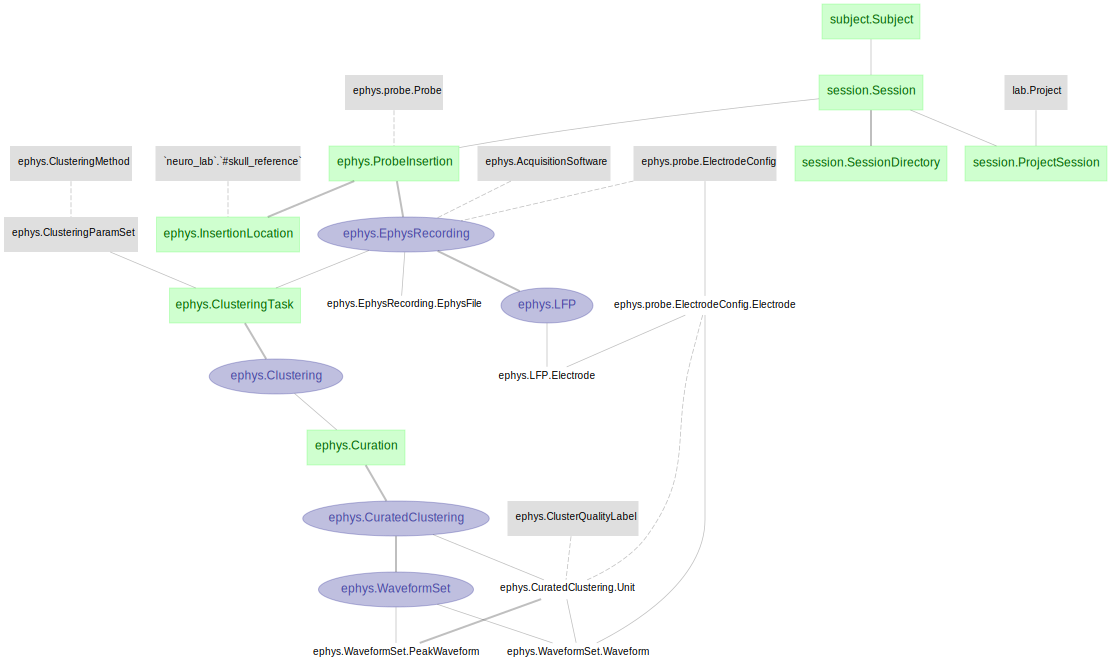

In [5]:
dj.Diagram(ephys) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint query and fetch 


DataJoint provides abundant functions to query data and fetch. For a detailed tutorials, visit our [general tutorial site](https://playground.datajoint.io/)


Running through the pipeline, we have ingested data of subject6 session1 into the database. Here are some highlights of the important tables.

### `Subject` and `Session` tables

In [10]:
subject.Subject()

subject,sex,subject_birth_date,subject_description


In [11]:
session.Session()

subject,session_datetime


In [12]:
session_key = (session.Session & 'subject="subject6"' & 'session_datetime = "2021-01-15 11:16:38"').fetch1('KEY')
session_key

DataJointError: fetch1 should only return one tuple. 0 tuples found

### `ephys.ProbeInsertion` and `ephys.EphysRecording` tables

These tables stores the probe recordings within a particular session from one or more probes.

In [7]:
ephys.ProbeInsertion ()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject6,2021-01-15 11:16:38,0,17131311651
subject7,2021-01-15 11:16:38,0,17131311651


In [ ]:
ephys.EphysRecording & session_key

### `ephys.ClusteringTask` , `ephys.Clustering`, `ephys.Curation`, and `ephys.CuratedClustering`

+ Spike-sorting is performed on a per-probe basis with the details stored in `ClusteringTask` and `Clustering`

+ After the spike sorting, the results may go through curation process. 
    + If it did not go through curation, a copy of `ClusteringTask` entry was inserted into table `ephys.Curation` with the `curation_ouput_dir` identicial to the `clustering_output_dir`. 
    + If it did go through a curation, a new entry will be inserted into `ephys.Curation`, with a `curation_output_dir` specified.
    + `ephys.Curation` supports multiple curations of a clustering task.

In [8]:
ephys.ClusteringTask * ephys.Clustering

subject,session_datetime,insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation",clustering_time time of generation of this set of clustering results,package_version
subject6,2021-01-15 11:16:38,0,0,subject6/session1/towersTask_g0_imec0,load,2021-06-07 17:15:12,


In our example workflow, `curation_output_dir` is the same as `clustering_output_dir`

In [9]:
ephys.Curation * ephys.CuratedClustering

subject,session_datetime,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
subject6,2021-01-15 11:16:38,0,0,1,2021-04-28 15:47:01,subject6/session1/towersTask_g0_imec0,0,0,


In [10]:
ephys.Curation()

subject,session_datetime,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
subject6,2021-01-15 11:16:38,0,0,1,2021-04-28 15:47:01,subject6/session1/towersTask_g0_imec0,0,0,


In [14]:
ephys.Curation.proj('subject', 'curation_time','curation_output_dir','quality_control','manual_curation')

subject,session_datetime,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?
subject6,2021-01-15 11:16:38,0,0,1,2021-04-28 15:47:01,subject6/session1/towersTask_g0_imec0,0,0


### Spike-sorting results are stored in `ephys.CuratedClustering`,  `ephys.WaveformSet.Waveform`

In [ ]:
ephys.CuratedClustering.Unit & session_key

Let's pick one probe insertion and one `curation_id`, and further inspect the clustering results.

In [ ]:
curation_key = (ephys.CuratedClustering & session_key & 'insertion_number = 0' & 'curation_id=1').fetch1('KEY')

In [ ]:
ephys.CuratedClustering.Unit & curation_key

### Generate a raster plot

Let's try a raster plot - just the "good" units

In [ ]:
ephys.CuratedClustering.Unit & curation_key & 'cluster_quality_label = "good"'

In [ ]:
units, unit_spiketimes = (ephys.CuratedClustering.Unit 
                          & curation_key 
                          & 'cluster_quality_label = "good"').fetch('unit', 'spike_times')

In [ ]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(32, 16))
ax.plot(x, y, '|')
ax.set_xlabel('Time (s)');
ax.set_ylabel('Unit');

### Plot waveform of a unit

Let's pick one unit and further inspect

In [ ]:
unit_key = (ephys.CuratedClustering.Unit & curation_key & 'unit = 6').fetch1('KEY')

In [ ]:
ephys.CuratedClustering.Unit * ephys.WaveformSet.Waveform & unit_key

In [ ]:
unit_data = (ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key).fetch()

In [ ]:
unit_data

In [ ]:
sampling_rate = (ephys.EphysRecording & curation_key).fetch1('sampling_rate')/1000 # in kHz
plt.plot(np.r_[:unit_data['peak_electrode_waveform'].size] * 1/sampling_rate, unit_data['peak_electrode_waveform'])
plt.xlabel('Time (ms)');
plt.ylabel(r'Voltage ($\mu$V)');

## Summary and Next Step

This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.

## Question Categories
### DataJoint Questions
Question type:
1. Recall
2. exploratory
3. Recall
4. Recall/Synthesis
5. Recall/Synthesis


### Workflow Questions
Question type:
1. Exploratory
2. Exploratory
3. Inference
4. Understanding 
5. 

## DataJoint Questions

1. How would you go about exploring animal and lab schemas using dj.Diagram()? 
2. If you were curious about the sessions in the curation table done after 2021-01-15 9:00:00, how do you go about finding this using a DataJoint query?
3. Using the `.fetch1()`, show how you would get the key for subject 7 who had a session_datetime of 2021-01-16 10:20:58.
4. If we wanted to get a session from the session.Session table that took place before 2021-01-16 10:20:58, what query could we run? (Hint: DataJoint offers inequalities to query) 
5. 






## Workflow Questions
#### We will create our own raster plot and waveform plot: 
1. Let us explore the `subject` and `session` tables once more to see if we can generate a plot on a new subject and session. 
2. Let us generate our own session_key for this new subject.
3. Now, let us generate a curation_key.   
4. Let us generate a unit_key and our unit_date. For unit_key, be sure to use the `ephys.CuratedClustering.Unit` table, your curation key, and we only want the curation_quality_label="good". Remember as well to specify 'KEY' in the fetch1 argument. And for unit_data, be sure to use `ephys.CuratedClustering.Unit` table,  * `ephys.WaveformSet.PeakWaveform` and your unit_key). Here the fetch method does not require an argument.
5. Let us generate our raster plot using our unit_key and unit_data.  
